<a href="https://colab.research.google.com/github/OsvaldoSan/TSC/blob/master/Unidad_1/Practica_2_Detector_de_autos_personas_autobuses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencias

In [ ]:
!pip install pytube
#pip install --upgrade opencv-python

     |████████████████████████████████| 51kB 4.0MB/s 


# Librerias

In [ ]:
import os
import cv2 
import numpy as np
from pytube import YouTube
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta as rd

In [ ]:
ini =datetime.now()

# Descargar video y convertir a frames

### Descargar de youtube 

In [ ]:
nombre = 'shibuya_yolov3.mp4'

In [ ]:
#Creacióón de carpetas
os.mkdir('detecciones')
os.mkdir('frames')
os.mkdir('video')

In [ ]:
# Descargar video
url = "https://www.youtube.com/watch?v=6NLe4syTWgQ"
YouTube(url).streams.first().download('video')

'/content/video/Shibuya Crossing Full HD 渋谷駅 東京.mp4'

In [ ]:
! mv /content/video/* /content/video/Shibuya.mp4

### Convertir a frames

In [ ]:
cap = cv2.VideoCapture(os.path.join('video',os.listdir('video')[0]))
i=0
while(cap.isOpened()):
    ret, frame = cap.read()# Regresa un boolean si es que hay frame y un tensor del frame(tensor que es la imagen)
    if ret == False:
        break
    cv2.imwrite(os.path.join('frames','frame_%05d.jpg'%i),frame) # Guarda el frame en la dirección indicada
    i+=1
cap.release()# Regresa a cap al inicio, como los archivos cuando son manejados por punteros
cv2.destroyAllWindows()

## Leer frames

In [ ]:
frames = sorted([os.path.join('frames',x) for x in os.listdir('frames/')]) # Obtiene las direcciones y ordena los frames

In [ ]:
imagenes= list(map(lambda im:cv2.imread(im),frames)) # Carga la lista de imagenes(tensores) para python


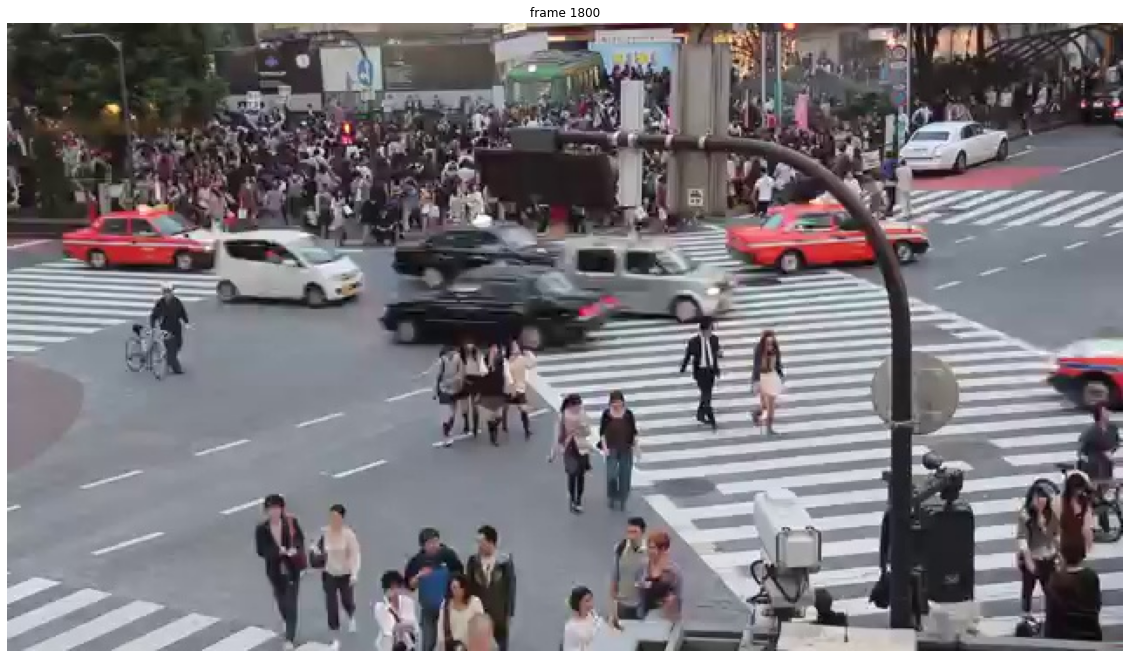

In [ ]:
#Visualización de una de las imagenes a través de python
i = 1800
plt.figure(figsize=(20,15))
plt.title(f'frame {i}')
plt.axis(False)
plt.imshow(cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB))

## Cargar CNN entrenada (YoloV3 sobre COCO)

In [ ]:
fuente = cv2.FONT_HERSHEY_PLAIN # Fuente es el tipo de letra

In [ ]:
#Etiquetas necesarias para yolov3
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

--2021-03-21 03:05:23--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2021-03-21 03:05:23 (23.7 MB/s) - ‘coco.names’ saved [625/625]



In [ ]:
# Pesos y configuraciones para yolov3
!wget "https://pjreddie.com/media/files/yolov3.weights"
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"

--2021-03-21 03:05:23--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  37.2MB/s    in 5.6s    

2021-03-21 03:05:29 (42.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2021-03-21 03:05:29--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      


In [ ]:
# Paso necesario
weightsPath = os.path.sep.join(["/content", "yolov3.weights"])
configPath = os.path.sep.join(["/content", "yolov3.cfg"])

In [ ]:
net = cv2.dnn.readNetFromDarknet('/content/yolov3.cfg', '/content/yolov3.weights')
with open("coco.names","r") as f:
    clases = [line.strip() for line in f.readlines()]

In [ ]:
#clases[0]
#clases[2]
clases[5]

'bus'

## Funciones para uso de la red

In [ ]:
capas_red=net.getLayerNames() # Es una lista con los nombres de las capas
capas_salida = [capas_red[i[0] - 1] for i in net.getUnconnectedOutLayers()] 
# El i[0] es para obtener el valor del array para saber cuales de las capas son de salida
capas_salida

['yolo_82', 'yolo_94', 'yolo_106']

In [ ]:
#propagar_red(imagenes[0],net)# Regresa un tensor

In [ ]:
def propagar_red(frame,red):
    capas_red = red.getLayerNames()# Genera lista de nombres
    capas_salida = [capas_red[i[0] - 1] for i in red.getUnconnectedOutLayers()]
    blob = cv2.dnn.blobFromImage(frame, 
                                 0.00392,
                                 (416,416),
                                 (0,0,0),
                                 True,
                                 crop=False) # Prepara el frame para que pueda pasar a la red
    red.setInput(blob)
    salidas = red.forward(capas_salida)
    return salidas

In [ ]:
# Caja contenedora de detecciones
def caja_detecciones(frame,contador):
  color1=np.array([255,0.1,0.1])
  cv2.rectangle(frame,(0,0),(135,102),color1,2)
  cv2.putText(frame,
                     "Personas="+" "+str(contador[0]),
                      (0,0+30),
                      fuente,
                      1,
                      (255,255,255),
                      2)
  cv2.putText(frame,
                     "Autos="+" "+str(contador[2]),
                     (0,60),
                     fuente,
                     1,
                     (255,255,255),
                     2)
  cv2.putText(frame,
                     "Autobuses="+" "+str(contador[5]),
                     (0,90),
                     fuente,
                     1,
                     (255,255,255),
                     2)

In [ ]:
def agregar_cajas_deteccion(salidas,frame,contador):
    alto,ancho,canales = frame.shape
    colores= np.random.uniform(0,255,size=(len(clases),3)) # colores aleatorios para las cajas
    ids=[]
    probas=[]
    cajas=[]
    for salida in salidas: # Es un tensor de los que regresa salidas
        for deteccion in salida: # Es un solo arreglo del tensor
            scores = deteccion[5:] #¿Por que os scores estan después de 5? Las primeras 5 son para las coordenadas
            id_ = np.argmax(scores)# Regresa la posición del máximo
            if (id_!=0 and id_!=2 and id_!=5):
              continue
            proba = scores[id_]
            if proba > 0.8:
                centro_x= int(deteccion[0]*ancho) # El arreglo del tensor regresa el centro_x escalado
                centro_y= int(deteccion[1]*alto)
                
                w = int(deteccion[2]*ancho)
                h = int(deteccion[3]*alto)
                x=int(centro_x - w/2)# Aparentemente es para tener coordenadas del punto de partida
                y=int(centro_y - h/2)
                cajas.append([x,y,w,h]) 
                probas.append(float(proba))
                ids.append(id_)# Junta los id que direon son el máximo de los scores, por que es la clase a la que pertenecen
    indices = cv2.dnn.NMSBoxes(cajas,probas,0.4,0.6)

    for i in range (len(cajas)):
        if i in indices:
            x,y,w,h = cajas[i]# Coordenadas para ubicar el objeto
            etiq = str(clases[ids[i]])# La clase a la que pertenece
            # Aumentar contador
            contador[ids[i]]+=1
            proba= probas[i]
            color = colores[ids[i]]
            cv2.rectangle(frame,(x,y),(x+w,y+h),color,2)
            cv2.putText(frame,
                        etiq+" "+str(round(proba,2)),
                        (x,y+30),
                        fuente,
                        1,
                        (255,255,255),
                        2)
    caja_detecciones(frame,contador)# Añade una caja con el acumulado de las detecciones
    return frame

In [ ]:
def colocar_autor(frame):
  font = cv2.FONT_HERSHEY_SIMPLEX
  cv2.putText(frame,'Creado por: ',(280,30),font,1,(0,255,255),2,cv2.LINE_AA)
  cv2.putText(frame,'Martin Osvaldo Santos Soto ',(135,60),font,1,(0,255,255),2,cv2.LINE_AA)

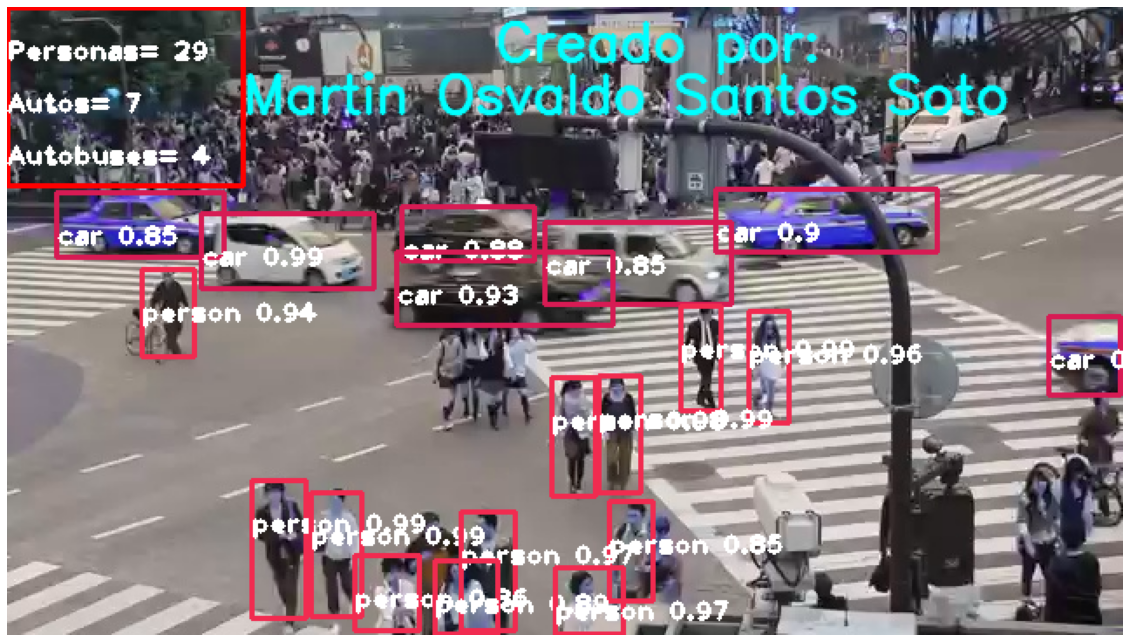

In [ ]:
#contador=[0,0,0,0,0,0]
i =1800
frame = imagenes[i].copy()
plt.figure(figsize=(20,15))
plt.axis(False)
colocar_autor(frame)
plt.imshow(agregar_cajas_deteccion(propagar_red(frame,net),frame,contador))

## Generar todas las detecciones de la red

In [ ]:
contador=[0,0,0,0,0,0]
for i,frame in enumerate(imagenes):
    if (i<400):
      colocar_autor(frame)
    cv2.imwrite('detecciones/%05d.png'%i,
                agregar_cajas_deteccion(propagar_red(frame,net),frame,contador))

## Conversión de imágenes con detecciones a video

In [ ]:
fps = 25

In [ ]:
imagenes = sorted([os.path.join('detecciones',
                                x) for x in os.listdir('detecciones/')])

In [ ]:
frames = []
for i,archivo in enumerate(imagenes):
    img = cv2.imread(archivo)
    alto, ancho,capas = img.shape
    tam = (ancho,alto)
    frames.append(img)
    
out = cv2.VideoWriter(nombre,
                      cv2.VideoWriter_fourcc(*'DIVX'),
                      fps,
                      tam)
for frame in frames:
    out.write(frame)

out.release()

In [ ]:
rd(datetime.now(),ini)

relativedelta(hours=+4, minutes=+48, seconds=+47, microseconds=+341299)

In [ ]:
!ls

coco.names   frames	  shibuya_yolov3.mp4  yolov3.cfg
detecciones  sample_data  video		      yolov3.weights


In [ ]:
from google.colab import files
files.download(nombre)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>